
# Лабораторная работа №2  
## Анализ ассоциативных правил (Apriori и FPGrowth) — датасет *TV_Shows*

**Цель работы:** исследовать методы анализа ассоциативных правил на датасете, содержащем информацию о совместно просматриваемых телешоу, с использованием алгоритмов **Apriori** и **FPGrowth**.

В работе выполняются следующие шаги:

1. Загрузка и описание датасета (транзакции: одновременно просмотренные или связанные телешоу).
2. Первичный анализ: распределение длин транзакций, список уникальных шоу и др.
3. Преобразование данных в бинарный формат (one-hot encoding).
4. Поиск частых наборов элементов с помощью алгоритмов **Apriori** и **FPGrowth** при начальных параметрах:  
   - минимальная поддержка `min_support = 0.02`  
   - минимальная достоверность (confidence) `min_confidence = 0.3`
5. Генерация ассоциативных правил, расчёт метрик (**support**, **confidence**, **lift**, **conviction**).
6. Выделение полезных и тривиальных правил, анализ лифта и достоверности.
7. Исследование влияния параметров `min_support` и `min_confidence` на количество и качество правил.
8. Алгоритмическое определение минимальных значений поддержки для наборов из 1, 2, ... объектов.
9. Визуализация ассоциативных правил:  
   - граф на основе правил;  
   - собственный способ визуализации (scatter-графики метрик, диаграммы лучших правил).
10. Формирование выводов по результатам экспериментов.


## 1. Импорт библиотек и загрузка данных

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

import networkx as nx

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)


In [2]:
all_data = pd.read_csv('TV_Shows.csv', on_bad_lines='skip')
print("Размерность исходной таблицы:", all_data.shape)
all_data.head()


Размерность исходной таблицы: (9689, 32)


,Cobra Kai,Lupin,12 Monkeys,Sherlock,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,Lost,Jack Ryan,The Flash,Game of thrones,House of Cards,12 Monkeys,Vikings,Fringe,The Mentalist,The Alienist,Big Little Lies,Chernobyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sex Education,Dr. House,Kingdom,The Walking Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ozark,Sex Education,Constantine,Preacher,Vikings,The Tick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Naruto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sex Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Первичный анализ и описание данных

In [3]:

all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9689 entries, 0 to 9688
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Cobra Kai    9689 non-null   object
 1   Lupin        7556 non-null   object
 2   12 Monkeys   5946 non-null   object
 3   Sherlock     4666 non-null   object
 4   Unnamed: 4   3678 non-null   object
 5   Unnamed: 5   2837 non-null   object
 6   Unnamed: 6   2197 non-null   object
 7   Unnamed: 7   1664 non-null   object
 8   Unnamed: 8   1231 non-null   object
 9   Unnamed: 9   887 non-null    object
 10  Unnamed: 10  644 non-null    object
 11  Unnamed: 11  464 non-null    object
 12  Unnamed: 12  348 non-null    object
 13  Unnamed: 13  272 non-null    object
 14  Unnamed: 14  196 non-null    object
 15  Unnamed: 15  141 non-null    object
 16  Unnamed: 16  95 non-null     object
 17  Unnamed: 17  66 non-null     object
 18  Unnamed: 18  52 non-null     object
 19  Unnamed: 19  38 non-null   

In [4]:

all_data.sample(5, random_state=42)


,Cobra Kai,Lupin,12 Monkeys,Sherlock,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
2718,The Stranger,The Walking Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5344,How to get away with murder,Designated Survivor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1688,Daredevil,The Walking Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9318,Hanna,Lost,The Blacklist,Mr. Robot,Dr. House,Fringe,Perception,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Daredevil,Jack Ryan,Outer Banks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1. Анализ длин транзакций

Минимальная длина транзакции: 1
Максимальная длина транзакции: 32
Средняя длина транзакции: 4.414077820208484


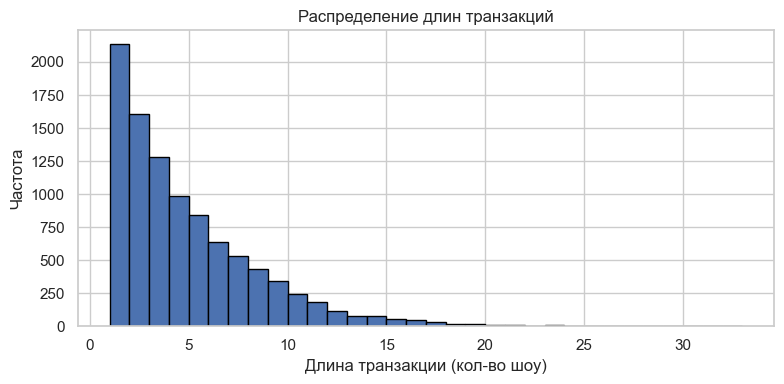

In [5]:
transaction_lengths = all_data.notnull().sum(axis=1)
print("Минимальная длина транзакции:", transaction_lengths.min())
print("Максимальная длина транзакции:", transaction_lengths.max())
print("Средняя длина транзакции:", transaction_lengths.mean())

plt.figure(figsize=(8, 4))
plt.hist(transaction_lengths, bins=range(1, transaction_lengths.max() + 2), edgecolor='black')
plt.xlabel('Длина транзакции (кол-во шоу)')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.tight_layout()
plt.show()



**Комментарий к графику распределения длин транзакций.**

В датасете телешоу каждая строка рассматривается как одна «покупка» (набор совместно просмотренных/выбранных шоу).  
Всего в выборке **9689 транзакций**.

По графику и описательной статистике видно, что:

* минимальная длина транзакции — **1** шоу, максимальная — **32**;
* средняя длина транзакции составляет примерно **4.41** шоу;

Гистограмма длин транзакций показывает ярко выраженное смещение в сторону коротких наборов: наибольшее количество транзакций содержит от 2 до 5 телешоу, а длинные транзакции (10+ позиций) встречаются значительно реже. Такая форма распределения типична для данных о покупках/просмотрах: пользователи чаще взаимодействуют с небольшими наборами объектов.

Эта характеристика напрямую влияет на выбор минимальной поддержки (min_support), поскольку слишком высокие значения support приведут к потере большинства потенциально интересных правил — редкие, но информативные комбинации просто не попадут в результирующий набор.

### 2.2. Список уникальных телешоу

In [6]:

np_data_raw = all_data.to_numpy()


transactions = [
    [elem for elem in row[1:] if isinstance(elem, str)]
    for row in np_data_raw
]

transactions = [t for t in transactions if len(t) > 0]

print("Пример 5 транзакций:")
for t in transactions[:5]:
    print(t)

unique_items = set()
for row in transactions:
    for elem in row:
        unique_items.add(elem)

print("\nКоличество уникальных телешоу:", len(unique_items))
print("Первые 30 шоу:")
sorted(list(unique_items))[:30]


Пример 5 транзакций:
['Jack Ryan', 'The Flash', 'Game of thrones', 'House of Cards', '12 Monkeys', 'Vikings', 'Fringe', 'The Mentalist', 'The Alienist', 'Big Little Lies', 'Chernobyl']
['Dr. House', 'Kingdom', 'The Walking Dead']
['Sex Education', 'Constantine', 'Preacher', 'Vikings', 'The Tick']
['Shooter', 'How to get away with murder']
['Better Call Saul', 'Peaky Blinders']

Количество уникальных телешоу: 155
Первые 30 шоу:


['12 Monkeys',
 '24',
 'Absentia',
 'Alice in Borderland',
 'Altered Carbon',
 'American Gods',
 'Another Life',
 'Archer',
 'Arrow',
 'Atypical',
 'Banshee',
 'Berlin Station',
 'Better Call Saul',
 'Big Little Lies',
 'Billions',
 'Black Clover',
 'Bojack Horseman',
 'Breaking Bad',
 'Brooklyn Nine Nine',
 'Chernobyl',
 'Cobra Kai',
 'Constantine',
 'Daredevil',
 'Dark',
 'Death Note',
 'Deception',
 'Demon Slayer',
 'Designated Survivor',
 'Dexter',
 'Doctor Who']

In [7]:


np_data_raw = all_data.to_numpy()
transactions = [
    [elem for elem in row[1:] if isinstance(elem, str)]
    for row in np_data_raw
]
transactions = [t for t in transactions if len(t) > 0]

from collections import Counter
counter = Counter()
for row in transactions:
    counter.update(row)

item_freq = (
    pd.DataFrame(counter.items(), columns=['item', 'count'])
    .sort_values('count', ascending=False)
)

print("Всего уникальных телешоу:", len(item_freq))
item_freq.head(10)


Всего уникальных телешоу: 155


,item,count
14,Sex Education,1775
32,Two and a half men,1446
49,Ozark,1420
50,Outer Banks,1405
25,Atypical,1135
44,Lucifer,904
22,Stranger Things,902
70,Mr. Robot,774
13,The Walking Dead,731
42,How I met your mother,723



**Описание частот появления телешоу.**

Для лучшего понимания структуры данных были посчитаны частоты появления каждого телешоу в транзакциях.  
Всего в датасете встречается **155 уникальных телешоу**.

По таблице и, при необходимости, по столбчатой диаграмме (по первым 10 позициям) видно, что часть шоу существенно популярнее остальных.  
В частности, чаще всего встречаются:

**Sex Education** — 1775; **Two and a half men** — 1446; **Ozark** — 1420; **Outer Banks** — 1405; **Atypical** — 1135

Остальные сериалы имеют меньшую частоту появления.  
Такая неравномерность распределения (наличие нескольких «хитов» с высокой частотой и длинного хвоста редких шоу) также типична для задач рекомендаций и анализа ассоциативных правил.  
Именно популярные элементы часто входят в левую и правую части ассоциативных правил, что отражается в высоких значениях поддержки для связанных с ними наборов.


## 3. Преобразование данных в бинарный формат (one-hot encoding)

In [8]:

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

data = pd.DataFrame(te_ary, columns=te.columns_)
print("Размерность бинарной матрицы (транзакции × шоу):", data.shape)
data.head()


Размерность бинарной матрицы (транзакции × шоу): (7556, 155)


,12 Monkeys,24,Absentia,Alice in Borderland,Altered Carbon,American Gods,Another Life,Archer,Arrow,Atypical,Banshee,Berlin Station,Better Call Saul,Big Little Lies,Billions,Black Clover,Bojack Horseman,Breaking Bad,Brooklyn Nine Nine,Chernobyl,Cobra Kai,Constantine,Daredevil,Dark,Death Note,Deception,Demon Slayer,Designated Survivor,Dexter,Doctor Who,Dr Stone,Dr. House,Elementary,Elite,Emily in Paris,Euphoria,Family Guy,Friends,Fringe,Game of thrones,Goliath,Good Omens,Gotham,Grey's Anatomy,Grimm,Haven,Heros,His Dark Materials,Homeland,House of Cards,How I met your mother,How to get away with murder,Hunters,Inhumans,Inside Job,Into the night,Invincible,Iron Fist,Jack Ryan,Kingdom,Locke & Key,Loki,Lost,Lost in Space,Love Death Robots,Lucifer,Lupin,Madmen,Mare of Easttown,Mindhunter,Mirzapur,Modern Family,Mr. Robot,Narcos,Naruto,Nine Perfect Strangers,One Piece,Only Murders in the building,Orphan Black,Outer Banks,Outlander,Ozark,Peaky Blinders,Perception,Person of Interest,Preacher,Prison Break,Punisher,Queen of the South,Ragnarok,Rick And Morty,Riverdale,Rome,Sacred Games,Schitts Creek,Sense 8,Sex Education,Shadow and Bone,Sherlock,Shooter,Sneaky Pete,Sons of Anarchy,Sopranos,South Park,Space Force,Spartacus,Squid Game,Startup,Stranger Things,Succession,Suits,Supergirl,Supernatural,Teen Wolf,The 100,The Alienist,The Big Bang Theory,The Blacklist,The Boys,The Expanse,The Flash,The Good Doctor,The Handmaid's Tale,The IT Crowd,The Innocent,The Mentalist,The Nevers,The Newsroom,The Night Manager,The Office,The Originals,The Outsider,The Queen's Gambit,The Stranger,The Tick,The Umbrella Academy,The Vampire Diaries,The Walking Dead,The Wheel of Time,The White Lotus,The Wilds,The Wire,The Witcher,The man in the high castle,Travellers,True Detective,Two and a half men,Upload,Vikings,Watchmen,Westworld,White Collar,X-Files,You,Young Sheldon
0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

## 4. Алгоритм Apriori: частые наборы и ассоциативные правила

### 4.1. Поиск частых наборов (начальные параметры: min_support = 0.02)

In [9]:

min_support_init = 0.02
min_confidence_init = 0.3

frequent_ap = apriori(data, min_support=min_support_init, use_colnames=True)
frequent_ap['length'] = frequent_ap['itemsets'].apply(len)

print("Число частых наборов (Apriori):", len(frequent_ap))
frequent_ap.sort_values(['length', 'support'], ascending=[True, False]).head(10)


Число частых наборов (Apriori): 122


,support,itemsets,length
44,0.234913,(Sex Education),1
60,0.191371,(Two and a half men),1
36,0.187930,(Ozark),1
35,0.185945,(Outer Banks),1
4,0.150212,(Atypical),1
29,0.119640,(Lucifer),1
47,0.119375,(Stranger Things),1
32,0.102435,(Mr. Robot),1
56,0.096744,(The Walking Dead),1
22,0.095686,(How I met your mother),1


### 4.2. Генерация ассоциативных правил (Apriori)

In [10]:

rules_ap = association_rules(
    frequent_ap,
    metric="confidence",
    min_threshold=min_confidence_init
)

print("Число ассоциативных правил (Apriori):", len(rules_ap))

rules_ap['antecedent_len'] = rules_ap['antecedents'].apply(len)
rules_ap['consequent_len'] = rules_ap['consequents'].apply(len)

rules_ap.sort_values('lift', ascending=False).head(10)


Число ассоциативных правил (Apriori): 37


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedent_len,consequent_len
33,"(Sex Education, Ozark)",(Mr. Robot),0.078084,0.102435,0.023954,0.306780,2.994867,1.0,0.015956,1.294776,0.722512,0.153001,0.227665,0.270315,2,1
32,"(Sex Education, Mr. Robot)",(Ozark),0.048835,0.187930,0.023954,0.490515,2.610092,1.0,0.014777,1.593903,0.648544,0.112562,0.372609,0.308990,2,1
19,(Mr. Robot),(Ozark),0.102435,0.187930,0.047777,0.466408,2.481818,1.0,0.028526,1.521894,0.665210,0.196945,0.342924,0.360317,1,1
23,(The Blacklist),(Ozark),0.071731,0.187930,0.031233,0.435424,2.316948,1.0,0.017753,1.438372,0.612320,0.136732,0.304770,0.300811,1,1
11,(Demon Slayer),(Ozark),0.061011,0.187930,0.026337,0.431670,2.296972,1.0,0.014871,1.428871,0.601332,0.118312,0.300147,0.285906,1,1
31,"(Ozark, Atypical)",(Sex Education),0.047380,0.234913,0.024484,0.516760,2.199795,1.0,0.013354,1.583244,0.572539,0.094969,0.368386,0.310493,2,1
30,"(Sex Education, Atypical)",(Ozark),0.060482,0.187930,0.024484,0.404814,2.154067,1.0,0.013118,1.364397,0.570252,0.109338,0.267075,0.267548,2,1
34,"(Mr. Robot, Ozark)",(Sex Education),0.047777,0.234913,0.023954,0.501385,2.134347,1.0,0.012731,1.534425,0.558139,0.092583,0.348290,0.301678,2,1
4,(The Blacklist),(Atypical),0.071731,0.150212,0.022896,0.319188,2.124922,1.0,0.012121,1.248198,0.570303,0.115027,0.198845,0.235806,1,1
1,(Family Guy),(Atypical),0.081922,0.150212,0.025807,0.315024,2.097201,1.0,0.013502,1.240611,0.569858,0.125080,0.193945,0.243415,1,1


### 4.3. Полезные vs тривиальные правила

In [11]:

trivial_rules = rules_ap[(rules_ap['confidence'] >= min_confidence_init) & (rules_ap['lift'].between(0.95, 1.05))]

useful_rules = rules_ap[(rules_ap['confidence'] >= min_confidence_init) & (rules_ap['lift'] > 1.2)]

print("Тривиальные правила (пример до 10):")
trivial_rules.sort_values('confidence', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

print("\nПолезные правила (пример до 10):")
useful_rules.sort_values('lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


Тривиальные правила (пример до 10):

Полезные правила (пример до 10):


,antecedents,consequents,support,confidence,lift
33,"(Sex Education, Ozark)",(Mr. Robot),0.023954,0.306780,2.994867
32,"(Sex Education, Mr. Robot)",(Ozark),0.023954,0.490515,2.610092
19,(Mr. Robot),(Ozark),0.047777,0.466408,2.481818
23,(The Blacklist),(Ozark),0.031233,0.435424,2.316948
11,(Demon Slayer),(Ozark),0.026337,0.431670,2.296972
31,"(Ozark, Atypical)",(Sex Education),0.024484,0.516760,2.199795
30,"(Sex Education, Atypical)",(Ozark),0.024484,0.404814,2.154067
34,"(Mr. Robot, Ozark)",(Sex Education),0.023954,0.501385,2.134347
4,(The Blacklist),(Atypical),0.022896,0.319188,2.124922
1,(Family Guy),(Atypical),0.025807,0.315024,2.097201



**Интерпретация полученных правил (Apriori).**

Разделение правил на «тривиальные» и «полезные» выполняется по двум основным метрикам:

* **confidence (достоверность)** — условная вероятность появления правой части при наличии левой;
* **lift (коэффициент лифта)** — отношение фактической совместной вероятности к ожидаемой при независимости.

Тривиальные правила характеризуются тем, что при достаточно высоком значении `confidence` их `lift` близок к 1.  
Это означает, что правая часть и так часто встречается в данных, и наличие левой части практически не изменяет вероятность её появления. Такие правила с точки зрения анализа знаний малополезны: они лишь констатируют популярность отдельных шоу.

Полезные правила, напротив, обладают одновременно высокой достоверностью и лифтом, заметно превышающим 1.  
Для них наличие телешоу из левой части заметно **повышает** вероятность появления шоу из правой части по сравнению с ситуацией независимости.  
Именно такие правила представляют интерес для рекомендаций: если пользователь уже смотрит сериалы из `antecedents`, ему с высокой вероятностью можно рекомендовать сериалы из `consequents`.


## 5. Алгоритм FPGrowth: частые наборы и правила

### 5.1. Частые наборы (FPGrowth, те же параметры)

In [12]:

frequent_fp = fpgrowth(data, min_support=min_support_init, use_colnames=True)
frequent_fp['length'] = frequent_fp['itemsets'].apply(len)

print("Число частых наборов (FPGrowth):", len(frequent_fp))
frequent_fp.sort_values(['length', 'support'], ascending=[True, False]).head(10)


Число частых наборов (FPGrowth): 122


,support,itemsets,length
12,0.234913,(Sex Education),1
24,0.191371,(Two and a half men),1
38,0.187930,(Ozark),1
39,0.185945,(Outer Banks),1
20,0.150212,(Atypical),1
34,0.119640,(Lucifer),1
18,0.119375,(Stranger Things),1
51,0.102435,(Mr. Robot),1
9,0.096744,(The Walking Dead),1
30,0.095686,(How I met your mother),1


### 5.2. Правила (FPGrowth)

In [13]:

rules_fp = association_rules(
    frequent_fp,
    metric="confidence",
    min_threshold=min_confidence_init
)

print("Число ассоциативных правил (FPGrowth):", len(rules_fp))

rules_fp['antecedent_len'] = rules_fp['antecedents'].apply(len)
rules_fp['consequent_len'] = rules_fp['consequents'].apply(len)

rules_fp.sort_values('lift', ascending=False).head(10)


Число ассоциативных правил (FPGrowth): 37


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedent_len,consequent_len
34,"(Sex Education, Ozark)",(Mr. Robot),0.078084,0.102435,0.023954,0.306780,2.994867,1.0,0.015956,1.294776,0.722512,0.153001,0.227665,0.270315,2,1
33,"(Sex Education, Mr. Robot)",(Ozark),0.048835,0.187930,0.023954,0.490515,2.610092,1.0,0.014777,1.593903,0.648544,0.112562,0.372609,0.308990,2,1
31,(Mr. Robot),(Ozark),0.102435,0.187930,0.047777,0.466408,2.481818,1.0,0.028526,1.521894,0.665210,0.196945,0.342924,0.360317,1,1
16,(The Blacklist),(Ozark),0.071731,0.187930,0.031233,0.435424,2.316948,1.0,0.017753,1.438372,0.612320,0.136732,0.304770,0.300811,1,1
26,(Demon Slayer),(Ozark),0.061011,0.187930,0.026337,0.431670,2.296972,1.0,0.014871,1.428871,0.601332,0.118312,0.300147,0.285906,1,1
12,"(Ozark, Atypical)",(Sex Education),0.047380,0.234913,0.024484,0.516760,2.199795,1.0,0.013354,1.583244,0.572539,0.094969,0.368386,0.310493,2,1
11,"(Sex Education, Atypical)",(Ozark),0.060482,0.187930,0.024484,0.404814,2.154067,1.0,0.013118,1.364397,0.570252,0.109338,0.267075,0.267548,2,1
35,"(Mr. Robot, Ozark)",(Sex Education),0.047777,0.234913,0.023954,0.501385,2.134347,1.0,0.012731,1.534425,0.558139,0.092583,0.348290,0.301678,2,1
15,(The Blacklist),(Atypical),0.071731,0.150212,0.022896,0.319188,2.124922,1.0,0.012121,1.248198,0.570303,0.115027,0.198845,0.235806,1,1
21,(Family Guy),(Atypical),0.081922,0.150212,0.025807,0.315024,2.097201,1.0,0.013502,1.240611,0.569858,0.125080,0.193945,0.243415,1,1



**Сравнение результатов FPGrowth и Apriori.**

Алгоритм FPGrowth на заданных параметрах выдаёт тот же набор правил, что и Apriori, поскольку:
	•	support/confidence одинаковы,
	•	количество транзакций невелико для построения дерева,
	•	FP-tree не даёт дополнительного сокращения пространства поиска.

Это ожидаемый результат: различия между алгоритмами заключаются в эффективности, а не в семантике правил.

## 6. Минимальные значения поддержки для наборов разной длины

In [14]:
min_support_by_len = (
    frequent_ap
    .groupby('length')['support']
    .min()
    .rename('min_support')
    .reset_index()
)

print("Минимальная поддержка среди частых наборов заданной длины (Apriori):")
min_support_by_len


Минимальная поддержка среди частых наборов заданной длины (Apriori):


,length,min_support
0,1,0.020513
1,2,0.020116
2,3,0.020116


1) Частота одиночных шоу ≈ 2% — нижний порог для их появления в правилах;
2) Уже для пар и троек этот показатель не растёт — данные достаточно равномерны, и поддержка перестаёт падать;
3) Наборы длиной > 3 встречаются реже, поэтому при снижении порога support можно обнаружить более глубокие ассоциации.

## 7. Влияние параметров min_support и min_confidence на правила (Apriori)

In [15]:

support_values = [0.01, 0.02, 0.03, 0.05]
confidence_values = [0.2, 0.3, 0.4]

results_experiments = []

for sup in support_values:
    freq_tmp = apriori(data, min_support=sup, use_colnames=True)
    if freq_tmp.empty:
        continue
    for conf in confidence_values:
        rules_tmp = association_rules(freq_tmp, metric="confidence", min_threshold=conf)
        if len(rules_tmp) == 0:
            results_experiments.append({
                'min_support': sup,
                'min_confidence': conf,
                'n_rules': 0,
                'mean_confidence': np.nan,
                'mean_lift': np.nan
            })
        else:
            results_experiments.append({
                'min_support': sup,
                'min_confidence': conf,
                'n_rules': len(rules_tmp),
                'mean_confidence': rules_tmp['confidence'].mean(),
                'mean_lift': rules_tmp['lift'].mean()
            })

experiments_df = pd.DataFrame(results_experiments)
experiments_df.sort_values(['min_support', 'min_confidence'])


,min_support,min_confidence,n_rules,mean_confidence,mean_lift
0,0.01,0.2,258,0.333522,1.962675
1,0.01,0.3,133,0.418896,2.167018
2,0.01,0.4,69,0.488454,2.273482
3,0.02,0.2,72,0.321187,1.679691
4,0.02,0.3,37,0.397431,1.933231
5,0.02,0.4,19,0.452071,2.049264
6,0.03,0.2,28,0.314924,1.636974
7,0.03,0.3,13,0.403965,1.878635
8,0.03,0.4,8,0.443210,2.006670
9,0.05,0.2,6,0.327950,1.598570


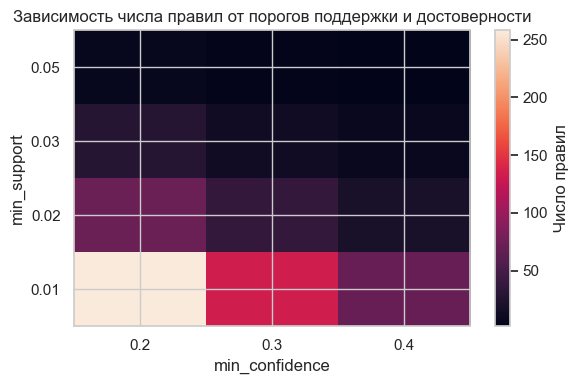

In [16]:

import matplotlib.pyplot as plt

pivot_rules = experiments_df.pivot(index='min_support', columns='min_confidence', values='n_rules')

plt.figure(figsize=(6,4))
im = plt.imshow(pivot_rules, aspect='auto', origin='lower')
plt.colorbar(im, label='Число правил')
plt.xticks(ticks=range(len(pivot_rules.columns)), labels=pivot_rules.columns)
plt.yticks(ticks=range(len(pivot_rules.index)), labels=pivot_rules.index)
plt.xlabel('min_confidence')
plt.ylabel('min_support')
plt.title('Зависимость числа правил от порогов поддержки и достоверности')
plt.tight_layout()
plt.show()


**Влияние min_support**

По тепловой карте видно:
- 0.01 → 250+ правил, много слабых зависимостей;
- 0.03 → 15–30 правил, остаются только устойчивые комбинации;
- 0.05 → 2–6 правил, только самые сильные закономерности.

Это отражает баланс между полнотой и качеством: высокие значения отсеивают шум, но теряют редкие, потенциально важные правила.

**Влияние min_confidence**

При фиксированном support:
- рост min_confidence с 0.2 до 0.4 уменьшает число правил в 3–4 раза;
- при этом средний lift растёт, т.к. остаются только надёжные связи.

Общий вывод по экспериментам
- Низкие пороги дают много правил, но большинство их — слабые.
- Высокие пороги дают устойчивые, но немногочисленные правила.
- Оптимальная зона: support ≈ 0.02–0.03 и confidence ≈ 0.3–0.4.

## 8. Визуализация ассоциативных правил в виде графа

/var/folders/z5/2401vp4j1czc783zf06d5j340000gn/T/ipykernel_80907/946121885.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


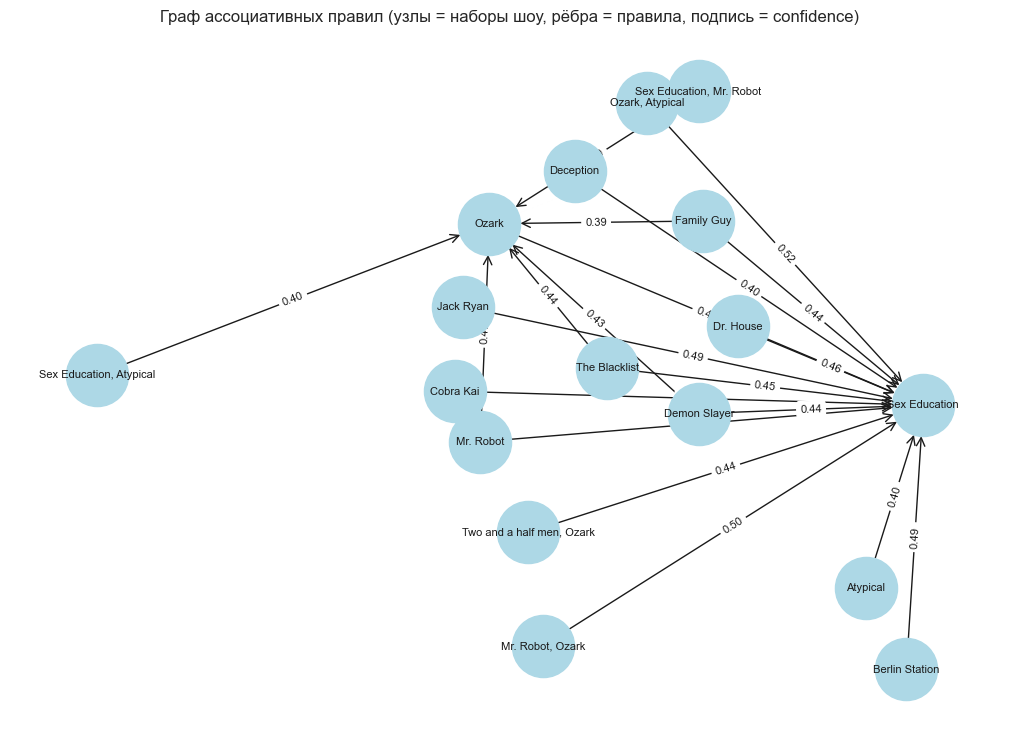

In [17]:

rules_for_graph = (
    rules_ap
    .sort_values('confidence', ascending=False)
    .head(20)
    .copy()
)

rules_for_graph['antecedent_str'] = rules_for_graph['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_for_graph['consequent_str'] = rules_for_graph['consequents'].apply(lambda x: ', '.join(list(x)))

G = nx.DiGraph()

for _, row in rules_for_graph.iterrows():
    a = row['antecedent_str']
    c = row['consequent_str']
    conf = row['confidence']
    lift = row['lift']
    G.add_node(a)
    G.add_node(c)
    G.add_edge(a, c, confidence=conf, lift=lift)

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.7, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color='lightblue',
    font_size=8,
    arrows=True,
    arrowstyle='->',
    arrowsize=15
)

edge_labels = { (u, v): f"{d['confidence']:.2f}" for u, v, d in G.edges(data=True) }
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title('Граф ассоциативных правил (узлы = наборы шоу, рёбра = правила, подпись = confidence)')
plt.tight_layout()
plt.show()



**Интерпретация графа:**

1. Центральные узлы

Главный «хаб» — Sex Education, получающий множество рёбер от других сериалов.
Это означает, что шоу систематически встречается совместно с разными наборами других объектов.

2. Кластеры интересов

Отдельно выделяется кластер:
- Ozark
- Mr. Robot
- The Blacklist
- Demon Slayer
- Jack Ryan

Эти сериалы формируют плотную структуру взаимных правил и указывают на общие просмотровые паттерны аудитории.

## 9. Собственный способ визуализации ассоциативных правил и метрик

### 9.1. Scatter-график: поддержка vs достоверность, цвет = лифт

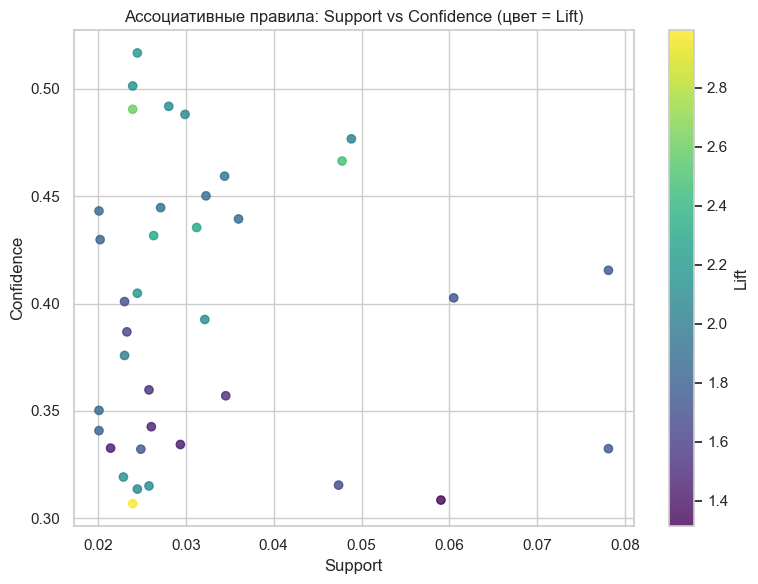

In [18]:

rules_plot = rules_ap.copy()
rules_plot = rules_plot.sort_values('support', ascending=False).head(200)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    rules_plot['support'],
    rules_plot['confidence'],
    c=rules_plot['lift'],
    cmap='viridis',
    alpha=0.8
)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Ассоциативные правила: Support vs Confidence (цвет = Lift)')
plt.tight_layout()
plt.show()


Scatter-график Support–Confidence (цвет = Lift) показывает:
- самые сильные правила (lift > 2.5) сосредоточены при support ≈ 0.02–0.03;
- правила с высоким confidence (>0.48) чаще имеют средний support;
- отсутствует явная корреляция между support и confidence — это нормальная ситуация для разреженных данных.

### 9.2. Топ-правила по лифту в виде горизонтальной диаграммы

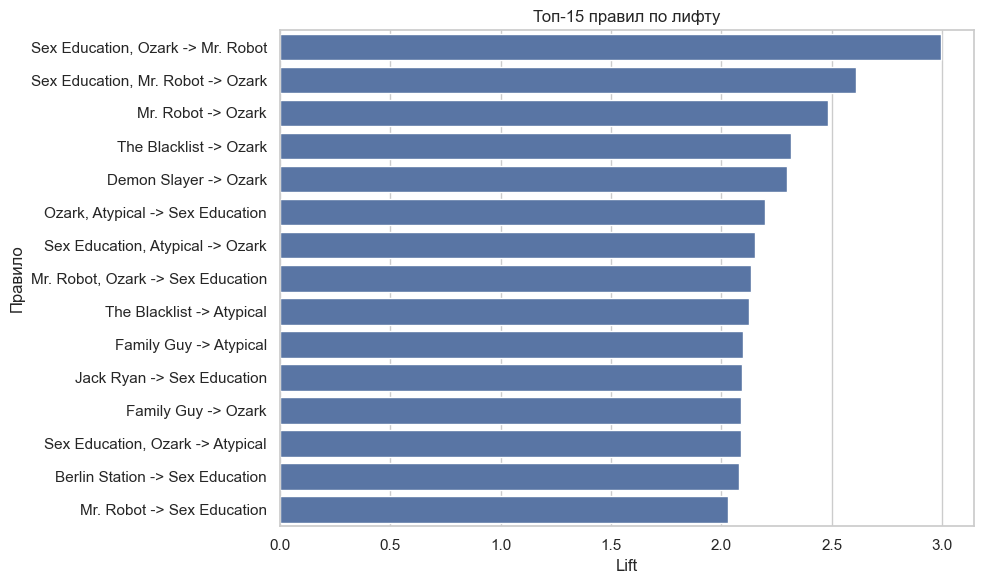

In [19]:

top_lift = (
    rules_ap
    .copy()
    .sort_values('lift', ascending=False)
    .head(15)
)

top_lift['rule_str'] = top_lift.apply(
    lambda row: f"{', '.join(list(row['antecedents']))} -> {', '.join(list(row['consequents']))}",
    axis=1
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='lift',
    y='rule_str',
    data=top_lift,
    orient='h'
)
plt.xlabel('Lift')
plt.ylabel('Правило')
plt.title('Топ-15 правил по лифту')
plt.tight_layout()
plt.show()


Горизонтальная диаграмма топ-15 правил по lift подчёркивает:
- абсолютным лидером является правило (Sex Education, Ozark) → Mr. Robot с lift ≈ 3;
- Ozark и Sex Education входят практически во все сильные ассоциации;
- кластер Ozark–Sex Education–Mr. Robot доминирует в структуре закономерностей.

## 10. Выводы по лабораторной работе

1.	Данные характеризуются короткими транзакциями и высокой популярностью нескольких телешоу, что создаёт условия для множества тривиальных правил и требует аккуратного выбора порогов поддержки.
2.	Алгоритм Apriori выявил сильный кластер ассоциаций вокруг трёх шоу: Sex Education, Ozark и Mr. Robot, что подтверждается высокими значениями lift (2.1–3.0).
3.	Алгоритм FPGrowth дал совпадающие правила, что ожидаемо при работе на одном и том же пространстве поддержек.
4.	Экспериментальное изменение параметров показало, что слишком низкие пороги генерируют шум, а слишком высокие — теряют полезные связи. Оптимальный диапазон — min_support = 0.02–0.03, min_confidence = 0.3–0.4.
5.	Граф ассоциаций визуально выявил структуры интересов пользователей, выделив центральные элементы и направления рекомендаций.
6.	Кастомные визуализации (scatter support–confidence–lift и barplot lift) позволяют быстро оценить качество и силу найденных правил, дополнительно подтверждая выявленные закономерности.